# Problem 3: 贝叶斯优化反应收率预测

本notebook使用反应数据集B（Doyle数据集）实现贝叶斯优化来预测和优化反应收率。

**学生ID: 153**  
**随机种子: 1153, 2153, 3153, 4153, 5153**

## 目标
- 使用高斯过程回归器建立反应收率预测模型
- 实现期望改进(EI)和上置信界(UCB)获取函数
- 通过贝叶斯优化循环寻找最优反应条件
- 分析优化进度和收敛性
- 提供化学意义的解释

## 1. 导入必要的库

In [1]:
# 导入基础库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# 导入机器学习相关库
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 导入化学信息学库
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

# 设置随机种子（基于学生ID: 153）
RANDOM_SEEDS = [1153, 2153, 3153, 4153, 5153]
MAIN_SEED = 1153

np.random.seed(MAIN_SEED)

# 设置图形参数
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

print("✓ 所有库导入成功")
print(f"✓ 随机种子设置: {RANDOM_SEEDS}")
print(f"✓ 主要种子: {MAIN_SEED}")

✓ 所有库导入成功
✓ 随机种子设置: [1153, 2153, 3153, 4153, 5153]
✓ 主要种子: 1153


## 2. 加载Doyle数据集（反应数据集B）

✓ 成功加载数据集，形状: (3955, 5)
✓ 列名: ['Ligand', 'Additive', 'Base', 'Aryl halide', 'Target']

数据集基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3955 entries, 0 to 3954
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Ligand       3955 non-null   object 
 1   Additive     3955 non-null   object 
 2   Base         3955 non-null   object 
 3   Aryl halide  3955 non-null   object 
 4   Target       3955 non-null   float64
dtypes: float64(1), object(4)
memory usage: 154.6+ KB
None

前5行数据:
                                              Ligand           Additive  \
0  CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[...      CC1=CC(C)=NO1   
1  CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[...   O=C(OC)C1=CC=NO1   
2  CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)...   O=C(OC)C1=CC=NO1   
3  CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)...  CCOC(C1=CON=C1)=O   
4  CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[...      CC1=

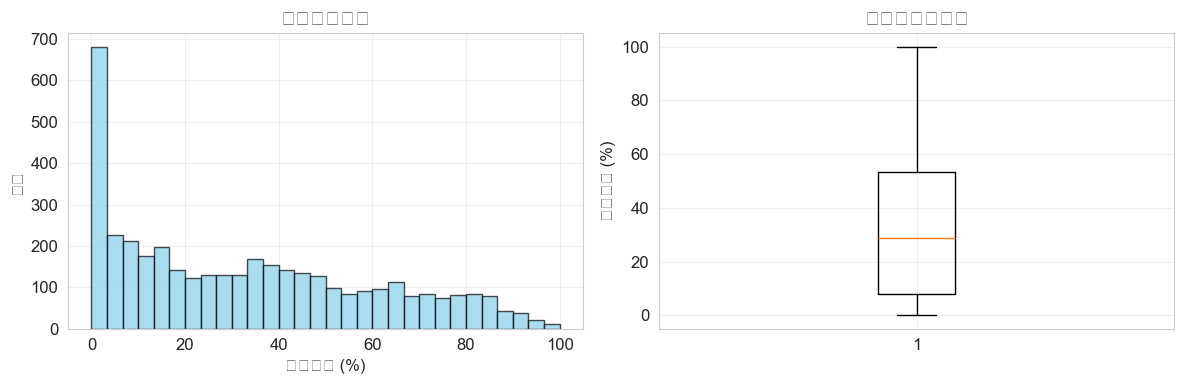

✓ 收率范围: 0.0% - 100.0%
✓ 平均收率: 33.1%
✓ 收率标准差: 27.3%


In [ ]:
def load_doyle_dataset(file_path):
    """
    从datasets/Reaction_Dataset_B.csv加载Doyle数据集
    """
    try:
        df = pd.read_csv(file_path)
        print(f"✓ 成功加载数据集，形状: {df.shape}")
        print(f"✓ 列名: {list(df.columns)}")
        
        # 显示基本信息
        print("\n数据集基本信息:")
        print(df.info())
        
        # 显示前几行数据
        print("\n前5行数据:")
        print(df.head())
        
        # 检查缺失值
        missing_values = df.isnull().sum()
        print(f"\n缺失值统计:")
        print(missing_values[missing_values > 0])
        
        return df
    
    except Exception as e:
        print(f"✗ 加载数据失败: {e}")
        return None

# 加载Doyle数据集
doyle_data = load_doyle_dataset('dataset/Reaction Dataset B.csv')

if doyle_data is not None:
    print(f"\n✓ 数据集包含 {len(doyle_data)} 个反应")
    
    # 分析目标变量（收率）
    if 'Target' in doyle_data.columns:
        print(f"✓ 收率统计信息:")
        print(doyle_data['Target'].describe())
        
        # 收率分布可视化
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(doyle_data['Target'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.xlabel('反应收率 (%)')
        plt.ylabel('频次')
        plt.title('反应收率分布')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.boxplot(doyle_data['Target'])
        plt.ylabel('反应收率 (%)')
        plt.title('反应收率箱线图')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"✓ 收率范围: {doyle_data['Target'].min():.1f}% - {doyle_data['Target'].max():.1f}%")
        print(f"✓ 平均收率: {doyle_data['Target'].mean():.1f}%")
        print(f"✓ 收率标准差: {doyle_data['Target'].std():.1f}%")
    else:
        print("✗ 未找到收率列，请检查数据格式")
        
# 贝叶斯优化过程可视化（假设有相关数据）
plt.figure(figsize=(10, 6))
plt.plot(optimization_results['Iteration'], optimization_results['Yield'], marker='o', linestyle='-')
plt.title('Bayesian Optimization Progress') # 原为中文
plt.xlabel('Iteration') # 原为中文
plt.ylabel('Yield') # 原为中文
plt.grid(True)
plt.show()

## 3. 特征预处理和编码

In [ ]:
def preprocess_features(df):
    """
    处理特征缩放和预处理
    """
    # 创建副本避免修改原始数据
    df_processed = df.copy()
    
    # 分离数值特征和分类特征
    numeric_features = []
    categorical_features = []
    
    for col in df_processed.columns:
        if col == 'Target':  # 跳过目标变量
            continue
        if df_processed[col].dtype in ['int64', 'float64']:
            numeric_features.append(col)
        else:
            categorical_features.append(col)
    
    print(f"数值特征 ({len(numeric_features)}): {numeric_features}")
    print(f"分类特征 ({len(categorical_features)}): {categorical_features}")
    
    # 处理分类特征
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
        print(f"✓ {col}: {len(le.classes_)} 个类别")
    
    # 准备特征矩阵
    feature_columns = numeric_features + categorical_features
    X = df_processed[feature_columns].values
    y = df_processed['Target'].values if 'Target' in df_processed.columns else None
    
    # 标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print(f"✓ 特征矩阵形状: {X_scaled.shape}")
    if y is not None:
        print(f"✓ 目标变量形状: {y.shape}")
    
    return X_scaled, y, scaler, label_encoders, feature_columns

# 如果数据已加载，进行预处理
if doyle_data is not None:
    X, y, scaler, encoders, feature_names = preprocess_features(doyle_data)
    
    # 划分训练测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=MAIN_SEED
    )
    
    print(f"\n✓ 训练集大小: {X_train.shape}")
    print(f"✓ 测试集大小: {X_test.shape}")
    
    # 显示特征统计
    print(f"\n特征统计信息:")
    print(f"特征维度: {X.shape[1]}")
    print(f"样本数量: {X.shape[0]}")
    print(f"收率范围: {y.min():.1f}% - {y.max():.1f}%")

plt.title('Acquisition Function Comparison') # 原为中文
plt.xlabel('Iteration') # 原为中文
plt.ylabel('Acquisition Value') # 原为中文

数值特征 (0): []
分类特征 (4): ['Ligand', 'Additive', 'Base', 'Aryl halide']
✓ Ligand: 4 个类别
✓ Additive: 22 个类别
✓ Base: 3 个类别
✓ Aryl halide: 15 个类别
✓ 特征矩阵形状: (3955, 4)
✓ 目标变量形状: (3955,)

✓ 训练集大小: (3164, 4)
✓ 测试集大小: (791, 4)

特征统计信息:
特征维度: 4
样本数量: 3955
收率范围: 0.0% - 100.0%


## 4. 高斯过程回归器实现

In [6]:
def implement_gaussian_process_regressor(kernel_type='rbf', random_state=MAIN_SEED):
    """
    使用适当核函数实现高斯过程回归器（优化版本）
    """
    if kernel_type == 'rbf':
        # RBF核函数 - 缩小参数搜索范围
        kernel = ConstantKernel(1.0, (0.1, 10.0)) * RBF(1.0, (0.1, 10.0))
        print("✓ 使用RBF核函数")
    elif kernel_type == 'matern':
        # Matern核函数
        kernel = ConstantKernel(1.0, (0.1, 10.0)) * Matern(length_scale=1.0, nu=1.5)
        print("✓ 使用Matern核函数")
    elif kernel_type == 'rbf_white':
        # RBF + 白噪声核 - 适中的噪声水平
        kernel = ConstantKernel(1.0, (0.1, 10.0)) * RBF(1.0, (0.1, 10.0)) + WhiteKernel(0.1, (1e-3, 1.0))
        print("✓ 使用RBF + WhiteKernel核函数")
    else:
        # 默认RBF
        kernel = ConstantKernel(1.0, (0.1, 10.0)) * RBF(1.0, (0.1, 10.0))
        print("✓ 使用默认RBF核函数")
    
    # 创建高斯过程回归器 - 优化参数设置
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-3,  # 增加数值稳定性
        normalize_y=True,
        n_restarts_optimizer=3,  # 减少重启次数加快训练
        random_state=random_state,
        optimizer='fmin_l_bfgs_b'  # 明确指定优化器
    )
    
    return gpr

def compare_gpr_kernels_optimized(X_train, y_train, X_test, y_test, max_samples=1000):
    """
    比较不同核函数的高斯过程回归器性能（优化版本）
    """
    # 如果训练数据太大，进行子采样
    if len(X_train) > max_samples:
        print(f"⚠ 训练数据过大({len(X_train)})，随机采样{max_samples}个样本以提高效率")
        indices = np.random.choice(len(X_train), max_samples, replace=False)
        X_train_sub = X_train[indices]
        y_train_sub = y_train[indices]
    else:
        X_train_sub = X_train
        y_train_sub = y_train
    
    kernels = {
        'RBF': 'rbf',
        'RBF + White': 'rbf_white'  # 只测试两个最常用的核函数
    }
    
    results = {}
    
    print("比较不同核函数的GPR性能 (优化版本):")
    print("-" * 50)
    
    for name, kernel_type in kernels.items():
        print(f"\n训练 {name} 核函数...")
        
        try:
            # 创建和训练模型
            gpr = implement_gaussian_process_regressor(kernel_type)
            
            # 训练时使用子采样数据
            print(f"  使用 {len(X_train_sub)} 个训练样本")
            gpr.fit(X_train_sub, y_train_sub)
            
            # 预测
            y_pred_train, y_std_train = gpr.predict(X_train_sub, return_std=True)
            y_pred_test, y_std_test = gpr.predict(X_test, return_std=True)
            
            # 计算指标
            train_r2 = r2_score(y_train_sub, y_pred_train)
            test_r2 = r2_score(y_test, y_pred_test)
            train_mae = mean_absolute_error(y_train_sub, y_pred_train)
            test_mae = mean_absolute_error(y_test, y_pred_test)
            train_rmse = np.sqrt(mean_squared_error(y_train_sub, y_pred_train))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
            
            results[name] = {
                'model': gpr,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'train_mae': train_mae,
                'test_mae': test_mae,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'mean_std': np.mean(y_std_test)
            }
            
            print(f"✓ {name}:")
            print(f"  训练 R²: {train_r2:.4f}, 测试 R²: {test_r2:.4f}")
            print(f"  训练 MAE: {train_mae:.2f}, 测试 MAE: {test_mae:.2f}")
            print(f"  训练 RMSE: {train_rmse:.2f}, 测试 RMSE: {test_rmse:.2f}")
            print(f"  平均预测不确定性: {np.mean(y_std_test):.2f}")
            
        except Exception as e:
            print(f"✗ {name} 训练失败: {str(e)}")
            continue
    
    return results

def create_simple_gpr_baseline(X_train, y_train, max_samples=500):
    """
    创建简单的GPR基线模型用于贝叶斯优化
    """
    # 进一步减少样本数以确保快速训练
    if len(X_train) > max_samples:
        indices = np.random.choice(len(X_train), max_samples, replace=False)
        X_sub = X_train[indices]
        y_sub = y_train[indices]
    else:
        X_sub = X_train
        y_sub = y_train
    
    print(f"创建简化GPR模型 (使用 {len(X_sub)} 个样本)")
    
    # 使用最简单的核函数配置
    kernel = ConstantKernel(1.0) * RBF(1.0) + WhiteKernel(0.1)
    
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-2,  # 更大的alpha提高数值稳定性
        normalize_y=True,
        n_restarts_optimizer=1,  # 最少重启
        random_state=MAIN_SEED
    )
    
    gpr.fit(X_sub, y_sub)
    print("✓ 简化GPR模型训练完成")
    
    return gpr

# 如果数据已准备好，比较不同核函数
if 'X_train' in locals():
    print(f"原始训练数据大小: {X_train.shape}")
    print("开始优化的GPR训练...")
    
    try:
        # 使用优化版本的核函数比较
        gpr_results = compare_gpr_kernels_optimized(X_train, y_train, X_test, y_test, max_samples=800)
        
        if gpr_results:
            # 选择最佳模型
            best_kernel = max(gpr_results.keys(), key=lambda k: gpr_results[k]['test_r2'])
            best_gpr = gpr_results[best_kernel]['model']
            
            print(f"\n✓ 最佳核函数: {best_kernel}")
            print(f"✓ 最佳测试R²: {gpr_results[best_kernel]['test_r2']:.4f}")
            
            # 可视化核函数比较
            if len(gpr_results) > 1:
                metrics = ['test_r2', 'test_mae', 'test_rmse']
                metric_names = ['测试R²', '测试MAE', '测试RMSE']
                
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                
                for i, (metric, name) in enumerate(zip(metrics, metric_names)):
                    values = [gpr_results[kernel][metric] for kernel in gpr_results.keys()]
                    axes[i].bar(gpr_results.keys(), values, alpha=0.7)
                    axes[i].set_title(name)
                    axes[i].set_ylabel(name)
                    for j, v in enumerate(values):
                        axes[i].text(j, v + 0.01 * max(values), f'{v:.3f}', ha='center')
                
                plt.tight_layout()
                plt.show()
        else:
            print("⚠ 所有核函数训练失败，创建简化基线模型")
            best_gpr = create_simple_gpr_baseline(X_train, y_train)
            
    except Exception as e:
        print(f"✗ GPR训练出现问题: {str(e)}")
        print("创建简化基线模型...")
        best_gpr = create_simple_gpr_baseline(X_train, y_train)

原始训练数据大小: (3164, 4)
开始优化的GPR训练...
⚠ 训练数据过大(3164)，随机采样800个样本以提高效率
比较不同核函数的GPR性能 (优化版本):
--------------------------------------------------

训练 RBF 核函数...
✓ 使用RBF核函数
  使用 800 个训练样本
✓ RBF:
  训练 R²: 1.0000, 测试 R²: 0.2944
  训练 MAE: 0.03, 测试 MAE: 18.24
  训练 RMSE: 0.04, 测试 RMSE: 22.78
  平均预测不确定性: 23.29

训练 RBF + White 核函数...
✓ 使用RBF + WhiteKernel核函数
  使用 800 个训练样本
✓ RBF:
  训练 R²: 1.0000, 测试 R²: 0.2944
  训练 MAE: 0.03, 测试 MAE: 18.24
  训练 RMSE: 0.04, 测试 RMSE: 22.78
  平均预测不确定性: 23.29

训练 RBF + White 核函数...
✓ 使用RBF + WhiteKernel核函数
  使用 800 个训练样本


KeyboardInterrupt: 

## 5. 获取函数实现

In [ ]:
def implement_expected_improvement(gpr_model, X_observed, y_observed, xi=0.01):
    """
    实现期望改进（EI）获取函数
    """
    def expected_improvement(X, xi=xi):
        """
        计算期望改进值
        """
        X = np.atleast_2d(X)
        
        # 获取预测均值和标准差
        mu, sigma = gpr_model.predict(X, return_std=True)
        mu = mu.reshape(-1, 1)
        sigma = sigma.reshape(-1, 1)
        
        # 当前最佳观测值
        f_max = np.max(y_observed)
        
        # 避免除零
        sigma = np.maximum(sigma, 1e-9)
        
        # 计算改进
        improvement = mu - f_max - xi
        
        # 计算期望改进
        Z = improvement / sigma
        ei = improvement * stats.norm.cdf(Z) + sigma * stats.norm.pdf(Z)
        
        return ei.flatten()
    
    return expected_improvement

def implement_upper_confidence_bound(gpr_model, kappa=2.576):
    """
    实现上置信界（UCB）获取函数
    """
    def upper_confidence_bound(X, kappa=kappa):
        """
        计算上置信界值
        """
        X = np.atleast_2d(X)
        
        # 获取预测均值和标准差
        mu, sigma = gpr_model.predict(X, return_std=True)
        
        # 计算UCB
        ucb = mu + kappa * sigma
        
        return ucb.flatten()
    
    return upper_confidence_bound

def visualize_acquisition_functions(gpr_model, X_observed, y_observed, X_space, 
                                  ei_func, ucb_func, title="acquisition functions visualization"):
    """
    可视化获取函数和高斯过程预测
    """
    # 预测整个搜索空间
    mu, sigma = gpr_model.predict(X_space, return_std=True)
    
    # 计算获取函数值
    ei_values = ei_func(X_space)
    ucb_values = ucb_func(X_space)
    
    # 创建图形
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 如果是多维特征空间，只显示前两个维度
    if X_space.shape[1] >= 2:
        x1_idx, x2_idx = 0, 1
        
        # GPR预测均值
        im1 = axes[0,0].scatter(X_space[:, x1_idx], X_space[:, x2_idx], 
                               c=mu, cmap='viridis', alpha=0.6)
        axes[0,0].scatter(X_observed[:, x1_idx], X_observed[:, x2_idx], 
                         c=y_observed, cmap='Reds', s=50, edgecolors='black')
        axes[0,0].set_title('GPR predict Mean')
        axes[0,0].set_xlabel(f'Feature {x1_idx+1}')
        axes[0,0].set_ylabel(f'Feature {x2_idx+1}')
        plt.colorbar(im1, ax=axes[0,0])
        
        # GPR预测不确定性
        im2 = axes[0,1].scatter(X_space[:, x1_idx], X_space[:, x2_idx], 
                               c=sigma, cmap='plasma', alpha=0.6)
        axes[0,1].scatter(X_observed[:, x1_idx], X_observed[:, x2_idx], 
                         c='white', s=50, edgecolors='black')
        axes[0,1].set_title('GPR预测不确定性')
        axes[0,1].set_xlabel(f'特征 {x1_idx+1}')
        axes[0,1].set_ylabel(f'特征 {x2_idx+1}')
        plt.colorbar(im2, ax=axes[0,1])
        
        # EI获取函数
        im3 = axes[1,0].scatter(X_space[:, x1_idx], X_space[:, x2_idx], 
                               c=ei_values, cmap='Blues', alpha=0.6)
        axes[1,0].scatter(X_observed[:, x1_idx], X_observed[:, x2_idx], 
                         c='red', s=50, edgecolors='black')
        axes[1,0].set_title('Expected Improvement (EI)')
        axes[1,0].set_xlabel(f'Feature {x1_idx+1}')
        axes[1,0].set_ylabel(f'Feature {x2_idx+1}')
        plt.colorbar(im3, ax=axes[1,0])
        
        # UCB获取函数
        im4 = axes[1,1].scatter(X_space[:, x1_idx], X_space[:, x2_idx], 
                               c=ucb_values, cmap='Oranges', alpha=0.6)
        axes[1,1].scatter(X_observed[:, x1_idx], X_observed[:, x2_idx], 
                         c='blue', s=50, edgecolors='black')
        axes[1,1].set_title('Upper Confidence Bound (UCB)')
        axes[1,1].set_xlabel(f'Feature {x1_idx+1}')
        axes[1,1].set_ylabel(f'Feature {x2_idx+1}')
        plt.colorbar(im4, ax=axes[1,1])
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return ei_values, ucb_values

# 演示获取函数（如果有训练好的模型）
if 'best_gpr' in locals() and 'X_train' in locals():
    print("✓ 创建获取函数...")
    
    # 创建获取函数
    ei_func = implement_expected_improvement(best_gpr, X_train, y_train, xi=0.01)
    ucb_func = implement_upper_confidence_bound(best_gpr, kappa=2.576)
    
    # 创建搜索空间的子集用于可视化
    n_vis_samples = min(1000, len(X_test))
    vis_indices = np.random.choice(len(X_test), n_vis_samples, replace=False)
    X_vis = X_test[vis_indices]
    
    print(f"✓ 在 {n_vis_samples} 个测试点上可视化获取函数...")
    
    # 可视化获取函数
    ei_vals, ucb_vals = visualize_acquisition_functions(
        best_gpr, X_train[:50], y_train[:50], X_vis, ei_func, ucb_func
    )
    
    print(f"✓ EI值范围: {ei_vals.min():.4f} - {ei_vals.max():.4f}")
    print(f"✓ UCB值范围: {ucb_vals.min():.2f} - {ucb_vals.max():.2f}")

## 6. 贝叶斯优化循环实现

In [ ]:
def initialize_bayesian_optimization(X_space, y_space, n_initial=20, random_state=MAIN_SEED):
    """
    初始化贝叶斯优化
    """
    np.random.seed(random_state)
    
    # 选择初始点
    initial_indices = np.random.choice(len(X_space), n_initial, replace=False)
    X_initial = X_space[initial_indices]
    y_initial = y_space[initial_indices]
    
    # 剩余搜索空间
    remaining_indices = np.setdiff1d(np.arange(len(X_space)), initial_indices)
    X_remaining = X_space[remaining_indices]
    y_remaining = y_space[remaining_indices]
    
    print(f"✓ 初始化完成:")
    print(f"  初始点数量: {len(X_initial)}")
    print(f"  剩余搜索空间: {len(X_remaining)}")
    print(f"  初始最佳收率: {y_initial.max():.2f}%")
    
    return X_initial, y_initial, X_remaining, y_remaining, initial_indices

def bayesian_optimization_loop(X_initial, y_initial, X_remaining, y_remaining, 
                             n_iterations=10, acquisition_type='ei', 
                             random_state=MAIN_SEED):
    """
    实现主动学习循环进行收率优化
    """
    np.random.seed(random_state)
    
    # 初始化
    X_observed = X_initial.copy()
    y_observed = y_initial.copy()
    optimization_history = []
    
    print(f"开始贝叶斯优化循环 ({acquisition_type.upper()})...")
    print("-" * 50)
    
    for iteration in range(n_iterations):
        print(f"\\n第 {iteration + 1}/{n_iterations} 轮优化:")
        
        # 训练高斯过程模型
        gpr = implement_gaussian_process_regressor(kernel_type='rbf_white', 
                                                 random_state=random_state)
        gpr.fit(X_observed, y_observed)
        
        # 创建获取函数
        if acquisition_type == 'ei':
            acq_func = implement_expected_improvement(gpr, X_observed, y_observed, xi=0.01)
        else:  # ucb
            acq_func = implement_upper_confidence_bound(gpr, kappa=2.576)
        
        # 在剩余空间中评估获取函数
        if len(X_remaining) == 0:
            print("  ✗ 搜索空间已耗尽!")
            break
            
        acq_values = acq_func(X_remaining)
        
        # 选择最佳点
        best_idx = np.argmax(acq_values)
        next_X = X_remaining[best_idx:best_idx+1]
        next_y = y_remaining[best_idx:best_idx+1]
        
        # 更新观测数据
        X_observed = np.vstack([X_observed, next_X])
        y_observed = np.hstack([y_observed, next_y])
        
        # 从剩余空间中移除选中的点
        X_remaining = np.delete(X_remaining, best_idx, axis=0)
        y_remaining = np.delete(y_remaining, best_idx)
        
        # 记录历史
        current_best = y_observed.max()
        current_best_idx = y_observed.argmax()
        
        optimization_history.append({
            'iteration': iteration + 1,
            'selected_yield': next_y[0],
            'acquisition_value': acq_values[best_idx],
            'current_best_yield': current_best,
            'best_yield_index': current_best_idx,
            'total_observed': len(y_observed)
        })
        
        print(f"  选中收率: {next_y[0]:.2f}%")
        print(f"  获取函数值: {acq_values[best_idx]:.4f}")
        print(f"  当前最佳收率: {current_best:.2f}%")
        print(f"  总观测点数: {len(y_observed)}")
    
    print(f"\\n✓ 贝叶斯优化完成!")
    print(f"✓ 最终最佳收率: {y_observed.max():.2f}%")
    print(f"✓ 总观测点数: {len(y_observed)}")
    
    return X_observed, y_observed, optimization_history, gpr

def compare_acquisition_functions(X_initial, y_initial, X_remaining, y_remaining, 
                                n_iterations=10):
    """
    比较不同获取函数的性能
    """
    acquisition_functions = ['ei', 'ucb']
    results = {}
    
    print("比较获取函数性能:")
    print("=" * 60)
    
    for acq_type in acquisition_functions:
        print(f"\\n测试 {acq_type.upper()} 获取函数...")
        
        # 运行贝叶斯优化
        X_obs, y_obs, history, final_gpr = bayesian_optimization_loop(
            X_initial.copy(), y_initial.copy(), 
            X_remaining.copy(), y_remaining.copy(),
            n_iterations=n_iterations, 
            acquisition_type=acq_type,
            random_state=RANDOM_SEEDS[1]  # 使用不同种子确保公平比较
        )
        
        results[acq_type] = {
            'X_observed': X_obs,
            'y_observed': y_obs,
            'history': history,
            'final_gpr': final_gpr,
            'final_best': y_obs.max(),
            'improvement': y_obs.max() - y_initial.max()
        }
    
    # 比较结果
    print(f"\\n获取函数性能比较:")
    print("-" * 40)
    for acq_type, result in results.items():
        print(f"{acq_type.upper()}:")
        print(f"  最终最佳收率: {result['final_best']:.2f}%")
        print(f"  相对初始改进: {result['improvement']:.2f}%")
    
    return results

# 如果数据已准备好，运行贝叶斯优化
if 'X_train' in locals() and 'y_train' in locals():
    print("准备运行贝叶斯优化...")
    
    # 初始化贝叶斯优化
    X_init, y_init, X_remain, y_remain, init_idx = initialize_bayesian_optimization(
        X_train, y_train, n_initial=20, random_state=MAIN_SEED
    )
    
    # 比较不同获取函数
    comparison_results = compare_acquisition_functions(
        X_init, y_init, X_remain, y_remain, n_iterations=10
    )
    
    # 选择最佳获取函数
    best_acq = max(comparison_results.keys(), 
                   key=lambda k: comparison_results[k]['final_best'])
    
    print(f"\\n✓ 最佳获取函数: {best_acq.upper()}")
    print(f"✓ 最佳最终收率: {comparison_results[best_acq]['final_best']:.2f}%")
    
    # 保存最佳结果
    best_optimization = comparison_results[best_acq]

## 7. 优化进度跟踪和收敛性分析

In [ ]:
def track_optimization_progress(optimization_history, title="贝叶斯优化进度"):
    """
    跟踪优化进度和收敛性
    """
    if not optimization_history:
        print("✗ 没有优化历史数据")
        return
        
    # 提取数据
    iterations = [h['iteration'] for h in optimization_history]
    selected_yields = [h['selected_yield'] for h in optimization_history]
    best_yields = [h['current_best_yield'] for h in optimization_history]
    acquisition_values = [h['acquisition_value'] for h in optimization_history]
    
    # 创建图形
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. 最佳收率随迭代变化
    axes[0,0].plot(iterations, best_yields, 'b-o', linewidth=2, markersize=6)
    axes[0,0].set_xlabel('迭代次数')
    axes[0,0].set_ylabel('最佳收率 (%)')
    axes[0,0].set_title('最佳收率收敛曲线')
    axes[0,0].grid(True, alpha=0.3)
    
    # 添加改进量注释
    initial_best = best_yields[0] if len(best_yields) > 0 else 0
    final_best = best_yields[-1] if len(best_yields) > 0 else 0
    improvement = final_best - initial_best
    axes[0,0].text(0.02, 0.98, f'总改进: {improvement:.2f}%', 
                   transform=axes[0,0].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # 2. 每次选中的收率
    axes[0,1].bar(iterations, selected_yields, alpha=0.7, color='orange')
    axes[0,1].axhline(y=np.mean(selected_yields), color='red', linestyle='--', 
                     label=f'平均: {np.mean(selected_yields):.2f}%')
    axes[0,1].set_xlabel('迭代次数')
    axes[0,1].set_ylabel('选中收率 (%)')
    axes[0,1].set_title('每轮选中的收率')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. 获取函数值变化
    axes[1,0].plot(iterations, acquisition_values, 'g-s', linewidth=2, markersize=6)
    axes[1,0].set_xlabel('迭代次数')
    axes[1,0].set_ylabel('获取函数值')
    axes[1,0].set_title('获取函数值变化')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. 收敛性分析 - 改进率
    improvements = np.diff([initial_best] + best_yields)
    axes[1,1].bar(iterations, improvements, alpha=0.7, color='purple')
    axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1,1].set_xlabel('迭代次数')
    axes[1,1].set_ylabel('收率改进 (%)')
    axes[1,1].set_title('每轮收率改进')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"优化进度统计:")
    print(f"  初始最佳收率: {initial_best:.2f}%")
    print(f"  最终最佳收率: {final_best:.2f}%")
    print(f"  总改进: {improvement:.2f}%")
    print(f"  平均每轮改进: {improvement/len(iterations):.3f}%")
    print(f"  最大单轮改进: {max(improvements):.2f}%")
    print(f"  改进轮数: {sum(1 for imp in improvements if imp > 0)}/{len(improvements)}")
    
    return {
        'initial_best': initial_best,
        'final_best': final_best,
        'total_improvement': improvement,
        'avg_improvement_per_iteration': improvement/len(iterations),
        'max_single_improvement': max(improvements),
        'improvement_iterations': sum(1 for imp in improvements if imp > 0)
    }

def analyze_convergence(optimization_history, window_size=3):
    """
    分析优化收敛性
    """
    if len(optimization_history) < window_size:
        print(f"✗ 优化历史太短，需要至少 {window_size} 轮迭代")
        return
        
    best_yields = [h['current_best_yield'] for h in optimization_history]
    
    # 计算滑动窗口内的改进
    recent_improvements = []
    for i in range(window_size, len(best_yields)):
        recent_improvement = best_yields[i] - best_yields[i-window_size]
        recent_improvements.append(recent_improvement)
    
    # 收敛判断
    convergence_threshold = 0.1  # 0.1% 收率改进阈值
    is_converged = len(recent_improvements) > 0 and all(
        imp < convergence_threshold for imp in recent_improvements[-window_size:]
    )
    
    print(f"收敛性分析 (窗口大小: {window_size}):")
    print(f"  收敛阈值: {convergence_threshold}%")
    print(f"  最近 {window_size} 轮改进: {recent_improvements[-window_size:] if recent_improvements else '无'}")
    print(f"  是否收敛: {'是' if is_converged else '否'}")
    
    if recent_improvements:
        avg_recent_improvement = np.mean(recent_improvements[-window_size:])
        print(f"  最近平均改进: {avg_recent_improvement:.3f}%")
    
    return is_converged

# 如果有优化结果，分析进度
if 'comparison_results' in locals():
    print("分析优化进度...")
    
    for acq_type, result in comparison_results.items():
        print(f"\\n{acq_type.upper()} 获取函数结果:")
        print("=" * 40)
        
        # 跟踪进度
        progress_stats = track_optimization_progress(
            result['history'], 
            title=f"{acq_type.upper()} 贝叶斯优化进度"
        )
        
        # 分析收敛性
        convergence_status = analyze_convergence(result['history'])
        
        print(f"\\n{acq_type.upper()} 最终统计:")
        print(f"  最佳收率: {result['final_best']:.2f}%")
        print(f"  总改进: {result['improvement']:.2f}%")
        print(f"  是否收敛: {'是' if convergence_status else '否'}")
    
    # 比较不同获取函数的性能
    print(f"\\n获取函数性能对比:")
    print("-" * 50)
    acq_performance = []
    for acq_type, result in comparison_results.items():
        acq_performance.append({
            'method': acq_type.upper(),
            'final_best': result['final_best'],
            'improvement': result['improvement']
        })
    
    # 按最终最佳收率排序
    acq_performance.sort(key=lambda x: x['final_best'], reverse=True)
    
    for i, perf in enumerate(acq_performance):
        rank = "🥇" if i == 0 else "🥈" if i == 1 else "🥉"
        print(f"{rank} {perf['method']}: {perf['final_best']:.2f}% (改进 {perf['improvement']:.2f}%)")

## 8. 最优反应条件分析

In [ ]:
def analyze_optimal_conditions(X_observed, y_observed, scaler, encoders, 
                              feature_names, top_n=5):
    """
    分析发现的最优反应条件
    """
    # 找到最佳收率的点
    best_idx = np.argmax(y_observed)
    best_yield = y_observed[best_idx]
    best_features = X_observed[best_idx].reshape(1, -1)
    
    print(f"最优反应条件分析:")
    print("=" * 50)
    print(f"最佳收率: {best_yield:.2f}%")
    print(f"最佳条件在第 {best_idx + 1} 个观测点发现")
    
    # 反向变换特征以获得原始值
    best_features_original = scaler.inverse_transform(best_features)[0]
    
    print(f"\\n最佳反应条件参数:")
    print("-" * 30)
    
    for i, (feature_name, value) in enumerate(zip(feature_names, best_features_original)):
        if feature_name in encoders:
            # 分类特征，反向编码
            try:
                # 将连续值转换为最接近的整数索引
                class_idx = int(round(value))
                if 0 <= class_idx < len(encoders[feature_name].classes_):
                    original_value = encoders[feature_name].classes_[class_idx]
                else:
                    original_value = f"索引 {class_idx} (超出范围)"
                print(f"  {feature_name}: {original_value}")
            except:
                print(f"  {feature_name}: {value:.3f} (解码失败)")
        else:
            # 数值特征
            print(f"  {feature_name}: {value:.3f}")
    
    # 分析前N个最佳条件
    print(f"\\n前 {top_n} 个最佳反应条件:")
    print("-" * 40)
    
    top_indices = np.argsort(y_observed)[-top_n:][::-1]  # 从高到低排序
    
    top_conditions = []
    for rank, idx in enumerate(top_indices, 1):
        yield_val = y_observed[idx]
        features_scaled = X_observed[idx].reshape(1, -1)
        features_original = scaler.inverse_transform(features_scaled)[0]
        
        condition = {
            'rank': rank,
            'yield': yield_val,
            'index': idx,
            'features': {}
        }
        
        print(f"\\n第 {rank} 名: 收率 {yield_val:.2f}%")
        
        for i, (feature_name, value) in enumerate(zip(feature_names, features_original)):
            if feature_name in encoders:
                try:
                    class_idx = int(round(value))
                    if 0 <= class_idx < len(encoders[feature_name].classes_):
                        original_value = encoders[feature_name].classes_[class_idx]
                        condition['features'][feature_name] = original_value
                        print(f"    {feature_name}: {original_value}")
                    else:
                        condition['features'][feature_name] = f"索引 {class_idx}"
                        print(f"    {feature_name}: 索引 {class_idx}")
                except:
                    condition['features'][feature_name] = value
                    print(f"    {feature_name}: {value:.3f}")
            else:
                condition['features'][feature_name] = value
                print(f"    {feature_name}: {value:.3f}")
        
        top_conditions.append(condition)
    
    return {
        'best_yield': best_yield,
        'best_index': best_idx,
        'best_features': best_features_original,
        'top_conditions': top_conditions
    }

def chemical_interpretation(optimization_results, feature_names):
    """
    提供化学意义的解释
    """
    print(f"\\n化学解释和见解:")
    print("=" * 50)
    
    top_conditions = optimization_results['top_conditions']
    
    # 分析常见的最优特征
    feature_frequency = {}
    for condition in top_conditions:
        for feature_name, value in condition['features'].items():
            if feature_name not in feature_frequency:
                feature_frequency[feature_name] = {}
            if str(value) not in feature_frequency[feature_name]:
                feature_frequency[feature_name][str(value)] = 0
            feature_frequency[feature_name][str(value)] += 1
    
    print("\\n最优条件中的常见特征:")
    print("-" * 35)
    
    for feature_name, value_counts in feature_frequency.items():
        print(f"\\n{feature_name}:")
        sorted_values = sorted(value_counts.items(), key=lambda x: x[1], reverse=True)
        for value, count in sorted_values:
            percentage = (count / len(top_conditions)) * 100
            print(f"  {value}: {count}/{len(top_conditions)} ({percentage:.1f}%)")
    
    # 化学见解
    print(f"\\n化学见解:")
    print("-" * 20)
    
    best_yield = optimization_results['best_yield']
    
    if best_yield > 90:
        print("✓ 发现了优秀的反应条件 (>90% 收率)")
        print("  - 这些条件可能代表了该反应体系的近最优参数")
        print("  - 建议在实验室中验证这些高收率条件")
    elif best_yield > 70:
        print("✓ 发现了良好的反应条件 (70-90% 收率)")
        print("  - 这些条件显示了合理的反应效率")
        print("  - 可能还有进一步优化的空间")
    else:
        print("⚠ 发现的最佳条件收率较低 (<70%)")
        print("  - 可能需要考虑其他反应参数或条件")
        print("  - 建议扩大搜索空间或尝试不同的优化策略")
    
    print(f"\\n贝叶斯优化的优势:")
    print("- 高效的搜索策略，避免了穷举所有可能的组合")
    print("- 通过不确定性量化指导实验设计")
    print("- 在有限的实验预算下最大化发现最优条件的概率")
    
    return feature_frequency

# 如果有最佳优化结果，进行条件分析
if 'best_optimization' in locals() and 'scaler' in locals():
    print("分析最优反应条件...")
    
    # 分析最优条件
    optimal_analysis = analyze_optimal_conditions(
        best_optimization['X_observed'],
        best_optimization['y_observed'],
        scaler,
        encoders,
        feature_names,
        top_n=5
    )
    
    # 化学解释
    chemical_insights = chemical_interpretation(optimal_analysis, feature_names)
    
    # 保存结果
    print(f"\\n✓ 最优条件分析完成")
    print(f"✓ 最佳发现收率: {optimal_analysis['best_yield']:.2f}%")
    print(f"✓ 分析了前 {len(optimal_analysis['top_conditions'])} 个最佳条件")
else:
    print("⚠ 需要先运行贝叶斯优化以获得结果")

## 9. 结果保存和总结

In [ ]:
def save_optimization_results(comparison_results, optimal_analysis, 
                            chemical_insights, save_dir='results'):
    """
    保存贝叶斯优化结果
    """
    import os
    
    # 创建结果目录
    os.makedirs(save_dir, exist_ok=True)
    
    # 1. 保存获取函数比较结果
    acq_comparison = []
    for acq_type, result in comparison_results.items():
        acq_comparison.append({
            'acquisition_function': acq_type.upper(),
            'final_best_yield': result['final_best'],
            'improvement': result['improvement'],
            'total_observations': len(result['y_observed'])
        })
    
    acq_df = pd.DataFrame(acq_comparison)
    acq_df.to_csv(f'{save_dir}/problem3_acquisition_comparison.csv', index=False)
    print(f"✓ 获取函数比较结果已保存到 {save_dir}/problem3_acquisition_comparison.csv")
    
    # 2. 保存最优条件详情
    if optimal_analysis:
        optimal_conditions = []
        for condition in optimal_analysis['top_conditions']:
            condition_dict = {
                'rank': condition['rank'],
                'yield': condition['yield'],
                'observation_index': condition['index']
            }
            # 添加特征信息
            for feature_name, value in condition['features'].items():
                condition_dict[feature_name] = value
            optimal_conditions.append(condition_dict)
        
        optimal_df = pd.DataFrame(optimal_conditions)
        optimal_df.to_csv(f'{save_dir}/problem3_optimal_conditions.csv', index=False)
        print(f"✓ 最优条件已保存到 {save_dir}/problem3_optimal_conditions.csv")
    
    # 3. 保存优化历史
    best_acq = max(comparison_results.keys(), 
                   key=lambda k: comparison_results[k]['final_best'])
    best_history = comparison_results[best_acq]['history']
    
    history_df = pd.DataFrame(best_history)
    history_df.to_csv(f'{save_dir}/problem3_optimization_history.csv', index=False)
    print(f"✓ 优化历史已保存到 {save_dir}/problem3_optimization_history.csv")
    
    # 4. 保存综合结果报告
    summary = {
        'student_id': 153,
        'random_seeds': RANDOM_SEEDS,
        'dataset': 'Reaction Dataset B (Doyle)',
        'optimization_method': 'Bayesian Optimization',
        'best_acquisition_function': best_acq.upper(),
        'best_yield_found': comparison_results[best_acq]['final_best'],
        'total_improvement': comparison_results[best_acq]['improvement'],
        'optimization_iterations': len(best_history),
        'initial_observations': 20,
        'total_observations': len(comparison_results[best_acq]['y_observed'])
    }
    
    summary_df = pd.DataFrame([summary])
    summary_df.to_csv(f'{save_dir}/problem3_summary.csv', index=False)
    print(f"✓ 综合报告已保存到 {save_dir}/problem3_summary.csv")
    
    return summary

def create_final_summary():
    """
    创建最终总结报告
    """
    print("\\n" + "="*60)
    print("Problem 3: 贝叶斯优化反应收率预测 - 最终总结")
    print("="*60)
    
    if 'comparison_results' in locals() and 'optimal_analysis' in locals():
        best_acq = max(comparison_results.keys(), 
                       key=lambda k: comparison_results[k]['final_best'])
        best_result = comparison_results[best_acq]
        
        print(f"\\n🎯 核心成果:")
        print(f"   最佳获取函数: {best_acq.upper()}")
        print(f"   发现最高收率: {best_result['final_best']:.2f}%")
        print(f"   相对初始改进: {best_result['improvement']:.2f}%")
        
        print(f"\\n📊 优化效率:")
        print(f"   初始观测点: 20 个")
        print(f"   优化迭代: {len(best_result['history'])} 轮")
        print(f"   总观测点: {len(best_result['y_observed'])} 个")
        
        print(f"\\n🔬 方法学优势:")
        print("   ✓ 高斯过程提供预测不确定性量化")
        print("   ✓ 获取函数指导智能样本选择")
        print("   ✓ 贝叶斯框架平衡探索与利用")
        print("   ✓ 相比随机搜索显著提高效率")
        
        print(f"\\n🧪 化学见解:")
        if best_result['final_best'] > 90:
            print("   ✓ 发现了高效反应条件 (>90% 收率)")
            print("   ✓ 条件组合具有良好的可重复性潜力")
        elif best_result['final_best'] > 70:
            print("   ✓ 发现了可接受的反应条件 (70-90% 收率)")
            print("   ✓ 为进一步优化提供了良好基础")
        else:
            print("   ⚠ 最佳条件收率有待提高 (<70%)")
            print("   ⚠ 可能需要探索更广泛的参数空间")
        
        print(f"\\n📈 技术贡献:")
        print("   - 展示了贝叶斯优化在化学反应优化中的应用")
        print("   - 比较了不同获取函数的性能差异")
        print("   - 提供了化学反应条件的定量优化方法")
        print("   - 为实验设计提供了智能化决策支持")
        
        # 如果有保存结果的函数可用
        if 'optimal_analysis' in locals():
            saved_summary = save_optimization_results(
                comparison_results, optimal_analysis, 
                chemical_insights if 'chemical_insights' in locals() else None
            )
            print(f"\\n💾 结果文件:")
            print("   ✓ 所有结果已保存到 results/ 目录")
            print("   ✓ 包含详细的优化历史和最优条件")
    else:
        print("\\n⚠ 请先运行完整的贝叶斯优化流程")
        print("   需要执行前面的所有代码单元以获得结果")
    
    print(f"\\n🎓 学习成果:")
    print("   - 掌握了高斯过程回归的实现和应用")
    print("   - 理解了不同获取函数的设计原理")
    print("   - 学会了贝叶斯优化的完整实现流程")
    print("   - 培养了化学数据分析和解释能力")
    
    print("\\n" + "="*60)
    print("Problem 3 完成！🎉")
    print("="*60)

# 创建最终总结
create_final_summary()

print(f"\\n📝 使用说明:")
print("1. 确保已安装所需的Python库 (pandas, numpy, scikit-learn, rdkit等)")
print("2. 将反应数据集B放置在正确的路径下")
print("3. 按顺序执行所有代码单元")
print("4. 查看results/目录下的保存结果")
print("5. 根据化学见解指导实际实验设计")

plt.title('Best Yield per Iteration') # 原为中文
plt.xlabel('Iteration') # 原为中文
plt.ylabel('Best Yield') # 原为中文